# **Projeto: Quais fatores mais influenciam no desempenho de um aluno no ENEM e como podemos ajudá-lo a melhorar sua performance?**

**Integrantes:** Hellen Cristine Silva Rosa (RA00319076), João Victor Porto (RA00311353), Laura Gabriel Murayama (RA00319321), Maria Eduarda Bonel Iribarnegaray (RA00318891), Vinícius Ferreira de Mendonça (RA00319760), Vitória de Fátima Teixeira (RA00320578)

### **Importando bibliotecas e definindo funções importantes**

In [1]:
SEED = 3

# loading environment variables
from dotenv import load_dotenv
load_dotenv()

# accelerating sklearn
from sklearnex import patch_sklearn
patch_sklearn()

# importing libraries
import os
import re
import psycopg2
import pandas as pd
import numpy as np
import joblib
import skops.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

# importing sklearn functions
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# establishing connection with DB
class db_connection():
    '''
    Instantiates a connection with the database.
    '''
    def __init__(self):
        self.DB_URI = os.environ.get('DB_URI')
         
    def __enter__(self):
        self.connection = psycopg2.connect(self.DB_URI)
        return self.connection
    
    def __exit__(self, *args):
        self.connection.close()

### **REQ#03-11: Treinamento de modelos**

Todos os modelos serão testados com 30% dos dados. A avaliação será feita a partir das métricas acurácia, precision, recall, F1 e matriz de confusão. Eles serão persistidos.

In [5]:
with db_connection() as conn, conn.cursor() as cursor:
    query = '''
    SELECT *
    FROM projeto_enem.filtered_aggregated_data
    ORDER BY "NU_INSCRICAO" ASC;
    '''

    cursor.execute(query)
    complete_data_fetched = cursor.fetchall()
    complete_data_columns = tuple(desc[0] for desc in cursor.description)


complete_data = pd.DataFrame(complete_data_fetched, columns=complete_data_columns)
complete_data

OperationalError: connection to server at "localhost" (::1), port 5432 failed: fe_sendauth: no password supplied


In [42]:
renda_inf_indexes = complete_data[complete_data['MICRODADOS_RENDA_PER_CAPITA'] == float('inf')].index

complete_data = complete_data.drop(index=renda_inf_indexes).reset_index(drop=True)
complete_data

,NU_INSCRICAO,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_SEXO,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ST_CONCLUSAO,MICRODADOS_TP_ANO_CONCLUIU,MICRODADOS_TP_ESCOLA,MICRODADOS_TP_ENSINO,MICRODADOS_IN_TREINEIRO,MICRODADOS_REGIAO_ESCOLA,...,MICRODADOS_TP_LINGUA,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,210054479101,2,F,3,2,0,2,1.0,0,Centro-Oeste,...,1,303.00,3.50,2.66,4.63,2.0,2.0,3.0,2.5,0.00
1,210054480429,3,M,1,2,0,3,1.0,0,Norte,...,0,707.00,4.00,0.00,0.33,3.0,2.0,2.0,2.5,0.00
2,210054480874,3,F,3,2,0,2,1.0,0,Norte,...,1,909.00,3.35,2.66,7.00,4.0,7.0,3.0,4.5,0.25
3,210054481135,3,F,1,2,0,3,1.0,0,Norte,...,0,1818.00,3.10,5.01,7.66,4.0,8.0,2.0,4.5,0.25
4,210054481966,3,F,3,2,0,2,1.0,0,Norte,...,1,0.00,3.75,4.02,7.70,2.0,2.0,2.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22162,210058025162,3,M,1,2,0,2,1.0,0,Nordeste,...,1,2727.00,3.50,2.32,4.62,4.0,2.0,3.0,3.5,0.50
22163,210058025171,3,M,2,2,0,2,1.0,0,Nordeste,...,0,151.50,3.35,0.00,5.32,4.0,3.0,3.0,4.5,0.25
22164,210058025427,3,M,1,2,0,3,1.0,0,Sudeste,...,1,3333.00,3.10,3.33,8.01,4.0,3.0,3.0,3.5,0.50
22165,210058025530,2,F,3,2,0,2,1.0,0,Nordeste,...,1,378.75,3.10,3.68,10.68,4.0,4.0,3.0,4.5,0.25


#### **Pré-processamento**

**nominal:** 'MICRODADOS_TP_SEXO', 'MICRODADOS_REGIAO_ESCOLA'

**numerical:** 'NU_INSCRICAO', 'MICRODADOS_TP_FAIXA_ETARIA', 'MICRODADOS_TP_COR_RACA', 'MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_TP_ESCOLA', 'MICRODADOS_TP_ENSINO', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_TP_LINGUA', 'MICRODADOS_RENDA_PER_CAPITA', 'HABESTUDO_ST_MAT_PERC_APR', 'HABESTUDO_GES_TEMP_PLAN_EST', 'HABESTUDO_PRAT_EST_PES', 'HABESTUDO_TECN_TP_ACES', 'HABESTUDO_PROB_ROT_EST', 'HABESTUDO_DIF_INFR', 'HABESTUDO_AJUD_TERC', 'HABESTUDO_AVAL_PROP_EXP'

In [43]:
nominal_features = list(set(complete_data.select_dtypes(include='object').columns.values))
numerical_features = list(set(complete_data.select_dtypes(exclude='object').columns.values))

In [44]:
nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
])

preprocessor = ColumnTransformer(transformers=[
    ('nominal', nominal_transformer, nominal_features),
], remainder='passthrough')

In [11]:
X = complete_data.drop(columns=['NU_INSCRICAO', 'MICRODADOS_NU_NOTA_MEDIA', 'MICRODADOS_NU_NOTA_CONCEITO'])

X_transformed = preprocessor.fit_transform(X)
y_numerical_transformed = complete_data['MICRODADOS_NU_NOTA_MEDIA']
y_categorical_transformed = complete_data['MICRODADOS_NU_NOTA_CONCEITO']

NameError: name 'complete_data' is not defined

In [46]:
preprocessor_feature_names = preprocessor.get_feature_names_out()
preprocessor_feature_names = [re.sub(r'.+__', '', item) for item in preprocessor_feature_names]

In [47]:
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor_feature_names)
X_transformed

,MICRODADOS_TP_SEXO_F,MICRODADOS_TP_SEXO_M,MICRODADOS_REGIAO_ESCOLA_Centro-Oeste,MICRODADOS_REGIAO_ESCOLA_Nordeste,MICRODADOS_REGIAO_ESCOLA_Norte,MICRODADOS_REGIAO_ESCOLA_Sudeste,MICRODADOS_REGIAO_ESCOLA_Sul,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ST_CONCLUSAO,...,MICRODADOS_TP_LINGUA,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,...,1.0,303.00,3.50,2.66,4.63,2.0,2.0,3.0,2.5,0.00
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,...,0.0,707.00,4.00,0.00,0.33,3.0,2.0,2.0,2.5,0.00
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,...,1.0,909.00,3.35,2.66,7.00,4.0,7.0,3.0,4.5,0.25
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,...,0.0,1818.00,3.10,5.01,7.66,4.0,8.0,2.0,4.5,0.25
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,...,1.0,0.00,3.75,4.02,7.70,2.0,2.0,2.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22162,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,1.0,2727.00,3.50,2.32,4.62,4.0,2.0,3.0,3.5,0.50
22163,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,...,0.0,151.50,3.35,0.00,5.32,4.0,3.0,3.0,4.5,0.25
22164,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0,...,1.0,3333.00,3.10,3.33,8.01,4.0,3.0,3.0,3.5,0.50
22165,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,...,1.0,378.75,3.10,3.68,10.68,4.0,4.0,3.0,4.5,0.25


In [48]:
columns_to_drop = ['MICRODADOS_TP_ST_CONCLUSAO', 'MICRODADOS_TP_ANO_CONCLUIU', 'MICRODADOS_IN_TREINEIRO', 'MICRODADOS_TP_PRESENCA_CN', 'MICRODADOS_TP_PRESENCA_CH', 'MICRODADOS_TP_PRESENCA_LC', 'MICRODADOS_TP_PRESENCA_MT', 'MICRODADOS_TP_SEXO_M', 'MICRODADOS_NU_ACERTOS_MEDIO', 'MICRODADOS_NU_ACERTOS_CN', 'MICRODADOS_NU_ACERTOS_CH', 'MICRODADOS_NU_ACERTOS_LC', 'MICRODADOS_NU_ACERTOS_MT', 'MICRODADOS_NU_NOTA_CN', 'MICRODADOS_NU_NOTA_CH', 'MICRODADOS_NU_NOTA_LC', 'MICRODADOS_NU_NOTA_MT', 'MICRODADOS_NU_NOTA_REDACAO', 'MICRODADOS_TP_STATUS_REDACAO', 'MICRODADOS_NU_NOTA_COMP1', 'MICRODADOS_NU_NOTA_COMP2', 'MICRODADOS_NU_NOTA_COMP3', 'MICRODADOS_NU_NOTA_COMP4', 'MICRODADOS_NU_NOTA_COMP5', 'MICRODADOS_NU_ACERTOS_TOTAL', 'MICRODADOS_TP_LINGUA']

X_transformed = X_transformed.drop(columns=columns_to_drop).reset_index(drop=True)
X_transformed

,MICRODADOS_TP_SEXO_F,MICRODADOS_REGIAO_ESCOLA_Centro-Oeste,MICRODADOS_REGIAO_ESCOLA_Nordeste,MICRODADOS_REGIAO_ESCOLA_Norte,MICRODADOS_REGIAO_ESCOLA_Sudeste,MICRODADOS_REGIAO_ESCOLA_Sul,MICRODADOS_TP_FAIXA_ETARIA,MICRODADOS_TP_COR_RACA,MICRODADOS_TP_ESCOLA,MICRODADOS_TP_ENSINO,MICRODADOS_RENDA_PER_CAPITA,HABESTUDO_ST_MAT_PERC_APR,HABESTUDO_GES_TEMP_PLAN_EST,HABESTUDO_PRAT_EST_PES,HABESTUDO_TECN_TP_ACES,HABESTUDO_PROB_ROT_EST,HABESTUDO_DIF_INFR,HABESTUDO_AJUD_TERC,HABESTUDO_AVAL_PROP_EXP
0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,303.00,3.50,2.66,4.63,2.0,2.0,3.0,2.5,0.00
1,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,707.00,4.00,0.00,0.33,3.0,2.0,2.0,2.5,0.00
2,1.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,1.0,909.00,3.35,2.66,7.00,4.0,7.0,3.0,4.5,0.25
3,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,3.0,1.0,1818.00,3.10,5.01,7.66,4.0,8.0,2.0,4.5,0.25
4,1.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,2.0,1.0,0.00,3.75,4.02,7.70,2.0,2.0,2.0,3.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22162,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,2727.00,3.50,2.32,4.62,4.0,2.0,3.0,3.5,0.50
22163,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0,151.50,3.35,0.00,5.32,4.0,3.0,3.0,4.5,0.25
22164,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,1.0,3333.00,3.10,3.33,8.01,4.0,3.0,3.0,3.5,0.50
22165,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,378.75,3.10,3.68,10.68,4.0,4.0,3.0,4.5,0.25


In [49]:
X_numerical_train, X_numerical_test, y_numerical_train, y_numerical_test = train_test_split(X_transformed, y_numerical_transformed, test_size=0.3, random_state=SEED)

X_categorical_train, X_categorical_test, y_categorical_train, y_categorical_test = train_test_split(X_transformed, y_categorical_transformed, test_size=0.3, random_state=SEED)

#### **kNN**

**Classificador**

In [70]:
knn_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=3)),
])

In [61]:
knn_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

Acurácia

In [71]:
knn_classifier_accuracy_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
knn_classifier_accuracy_scores.mean()

0.3341673337690981

Precisão

In [63]:
knn_classifier_precision_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
knn_classifier_precision_scores.mean()

0.3415554069490655

Recall

In [64]:
knn_classifier_recall_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
knn_classifier_recall_scores.mean()

0.3341453532426512

F1-score

In [65]:
knn_classifier_f1_scores = cross_val_score(knn_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
knn_classifier_f1_scores.mean()

0.32749725057474977

Matriz de confusão

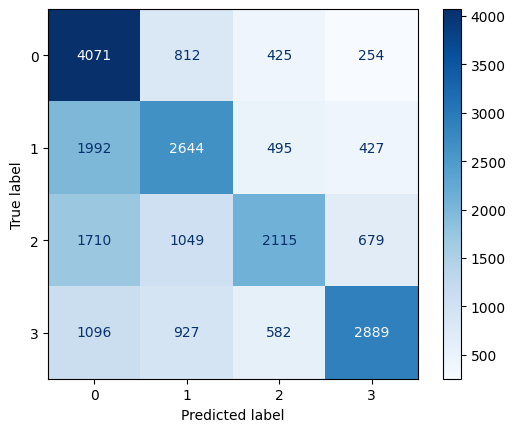

In [66]:
ConfusionMatrixDisplay.from_estimator(knn_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

**Regressor**


In [73]:
knn_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor(n_neighbors=3)),
])

In [74]:
knn_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', KNeighborsRegressor(n_neighbors=3))])

Erro médio absoluto

In [75]:
knn_regressor_mae_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
knn_regressor_mae_scores.mean()

65.3357859035053

Raiz Quadrada do Erro Médio

In [80]:
knn_regressor_rmse_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
knn_regressor_rmse_scores.mean()

82.77315460078373

Coeficiente de determinação

In [81]:
knn_regressor_r2_scores = cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
knn_regressor_r2_scores.mean()

0.05428630205750462

Erro percentual absoluto médio

In [82]:
knn_regressor_mape_scores = -1 * cross_val_score(knn_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
knn_regressor_mape_scores.mean()

0.1334434972752196

#### **Regressão Linear**

#### **Regressão Logística**

#### **Naive Bayes**

#### **SVM**

#### **Random Forest**

**Classificador**

In [51]:
randomforest_classifier_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=SEED)),
])

In [52]:
randomforest_classifier_pipe.fit(X_categorical_train, y_categorical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=3))])

In [53]:
randomforest_classifier_accuracy_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='balanced_accuracy')
randomforest_classifier_accuracy_scores.mean()

0.3937395253152843

In [76]:
randomforest_classifier_precision_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='precision_weighted')
randomforest_classifier_precision_scores.mean()

0.38223161073101763

In [ ]:
randomforest_classifier_recall_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='recall_weighted')
randomforest_classifier_recall_scores.mean()

In [ ]:
randomforest_classifier_f1_scores = cross_val_score(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cv=5, scoring='f1_weighted')
randomforest_classifier_f1_scores.mean()

In [ ]:
ConfusionMatrixDisplay.from_estimator(randomforest_classifier_pipe, X_transformed, y_categorical_transformed, cmap='Blues')
plt.show()

In [ ]:
randomforest_classifier_feature_importances = pd.Series(randomforest_classifier_pipe['classifier'].feature_importances_, index=X_categorical_train.columns)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.sort_values(ascending=False)
randomforest_classifier_feature_importances = randomforest_classifier_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_classifier_feature_importances

**Regressor**

In [77]:
randomforest_regressor_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=SEED)),
])

In [78]:
randomforest_regressor_pipe.fit(X_numerical_train, y_numerical_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [79]:
randomforest_regressor_mae_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_error')
randomforest_regressor_mae_scores.mean()

57.09945547776239

In [ ]:
randomforest_regressor_rmse_scores = -1 * cross_val_score(randomforest_regressor_pipe, x_transformed, y_numerical_transformed, cv=5, scoring='neg_root_mean_squared_error')
randomforest_regressor_rmse_scores.mean()

In [ ]:
randomforest_regressor_r2_scores = cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='r2')
randomforest_regressor_r2_scores.mean()

In [ ]:
randomforest_regressor_mape_scores = -1 * cross_val_score(randomforest_regressor_pipe, X_transformed, y_numerical_transformed, cv=5, scoring='neg_mean_absolute_percentage_error')
randomforest_regressor_mape_scores.mean()

In [ ]:
randomforest_regressor_feature_importances = pd.Series(randomforest_regressor_pipe['regressor'].feature_importances_, index=X_numerical_train.columns)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.sort_values(ascending=False)
randomforest_regressor_feature_importances = randomforest_regressor_feature_importances.apply(lambda x: round(100*x, 2))
randomforest_regressor_feature_importances